# LVDT demodulation using Extended Kalman Filter

Copyright &copy; 2024 Richard Hacker  
License: CC BY-SA


# Introduction

A linear variable differential transformer (LVDT) is a transducer that is used to measure displacement. It is an extremely robust transducer and can be used in harsh environments. The structure and equivalent circuit is shown in the diagram below.

It is a device with three coils wound over a moveable low permeability magnetic core linking the magnetic path between the coils. The primary center coil is excited with sine wave AC signal, typically a few kiloherz. Depending on the core position, magnetic flux is coupled more or less with the outer two secondary sense coils on either side of the excitation coil. Measuring the signal in these coils allows one to determine the core position.

Various techniques can be used to determine the core position. In this article, a Extended Kalman Filter is used to determine the position of the core. The filter only requires the two secondary voltages, sampled at least a decade faster than the excitation frequency. Not only is the position detected, but as a by-product the excitation frequency and a sine/cosine signal in sync with the excitation.

The Kalman Fitler requires a state space representation of the observed system. This involves defining state and output vectors and also describing how the state evolves over time.

These vectors are required to determine the following matrices that are needed to use the Kalman Filter:
   * state transition matrix $\mathbf \Phi_n$
   * state disturbance cross correlation matrix $\mathbf Q_n$
   * system output matrix $\mathbf H_n$
   * measurement noise cross correlation matrix $\mathbf R_n$

The Kalman Filter is then just an algortihm that is applied using these matrices.

# State and output vectors

Start by defining the state vector:

$$
\mathbf{x}_n = \begin{bmatrix}c_n\\s_n\\s_\Omega\\ \alpha \\\beta\end{bmatrix}
= \begin{bmatrix} A\,\cos n\Omega\\A\,\sin n\Omega \\ \sin\Omega \\ \alpha \\ \beta\end{bmatrix}
$$

where:
   * $c_n$, $s_n$ are the cosine and sine components of the excitation
   * $A$ excitation amplitude
   * $\Omega$ is the discrete excitation frequency, with $|\Omega| \ll \pi  \implies |s_\Omega| \ll 1$
   * $\alpha$  is the LVDT displacement, with $\alpha \in [-1, 1]$
   * $\beta$  is the LVDT phase shift, with $\beta \in [-1, 1]$
   
Notice that we are using $s_\Omega = \sin \Omega$ instead of the discrete frequency $\Omega$ in the state equation, simplifying the analysis later on.

The output of an LVDT is the voltage on the two output coils. The voltage on one coil is $(1 + \alpha)$ and the other $(1 - \alpha)$ of the excitation $s_n$, together with a phase shift:

$$
\begin{align}
V_{1,n} &= (1 + \alpha)\,s_n + \beta\,c_n\\
V_{2,n} &= (1 - \alpha)\,s_n - \beta\,c_n\\
\end{align}
$$

However, we will be using the sum and difference of these signals in the Kalman filter, making the two signals orthoganal to each other:

$$
\mathbf y_n = \begin{bmatrix}V_{1,n} + V_{2,n}\\V_{1,n} - V_{2,n}\end{bmatrix}
= \begin{bmatrix}2\,s_n\\ 2\,\alpha\,s_n + 2\,\beta\,c_n\end{bmatrix}
$$

## State transition matrix

Now let's consider the evolution of the state vector at point $n+1$, taking model disturbance into account:

$$
\mathbf F_n = \mathbf{x}_{n+1} 
= \Phi(\mathbf x_n) + \mathbf w_n
= \begin{bmatrix} A\,\cos (n+1)\Omega \\ A\,\sin (n+1)\Omega \\ s_\Omega \\ \alpha \\ \beta\end{bmatrix}
+ \begin{bmatrix} \Delta A\,\cos n\Omega \\\Delta A\,\sin n\Omega \\\Delta s_\Omega \\ \Delta\alpha \\ \Delta\beta\end{bmatrix}
$$

where:
   * $\Phi(\mathbf x_n)$ expresses the new state in terms of the previous state
   * $\mathbf w_n$ expresses the unknown state disturbance
   * $\Delta A$, $\Delta s_\Omega$, $\Delta \alpha$ and $\Delta \beta$ are zero mean random numbers with variance $\sigma_A^2$, $\sigma_\Omega^2$, $\sigma_\alpha^2$ and $\sigma_\beta^2$ respectively


Now let's have a closer look at the state transition, expanding using trignometric identities for the sum of angles:

$$
\Phi(\mathbf x_n)
= \begin{bmatrix} A\,\cos (n+1)\Omega\\A\,\sin (n+1)\Omega\\s_\Omega\\\alpha\\\beta\end{bmatrix}
= \begin{bmatrix}
    A\,(\cos n\Omega\,\cos\Omega - \sin n\Omega\,\sin\Omega)\\
    A\,(\sin n\Omega\,\cos\Omega + \cos n\Omega\,\sin\Omega)\\
    s_\Omega\\
    \alpha\\
    \beta
\end{bmatrix}
= \begin{bmatrix}
    c_n\,c_\Omega - s_n\,s_\Omega\\
    s_n\,c_\Omega + c_n\,s_\Omega\\
    s_\Omega\\
    \alpha\\
    \beta
\end{bmatrix}
$$

where
$$
c_\Omega = \cos \Omega = \sqrt{1 - s_\Omega^2}
$$

For the Kalman filter, we need the discrete state transition matrix $\mathbf \Phi_n$

$$
\Phi(\mathbf x_n) = \mathbf \Phi_n\,\mathbf x_n
$$

Since the state transition equation is non-linear in terms of its states, it is not possible to express it as a product of a state transition matrix and state vector.

Instead, we resort to the first order linear approximation using the partial differentiation of this equation to its states, which is a matrix where the colums are the partial derivatives of the equation to every state:

$$
\mathbf \Phi_n
\approx \frac{\partial}{\partial  \mathbf x_n}\, \Phi(\mathbf x_n)
= \begin{bmatrix}
\dfrac{\partial}{\partial c_n} &
\dfrac{\partial}{\partial s_n} &
\dfrac{\partial}{\partial s_\Omega} &
\dfrac{\partial}{\partial \alpha} &
\dfrac{\partial}{\partial \beta}
\end{bmatrix}\, \Phi(\mathbf x_n)
= \mathbf \Phi_n^*
$$

Evaluating the partial derivatives lets us approximate the state transition matrix as

$$
\mathbf \Phi_n^*
= \begin{bmatrix}
    1 & -s_\Omega & -s_n & 0 & 0\\
    s_\Omega & 1 & c_n & 0 & 0\\
    0 & 0 & 1 & 0 & 0\\
    0 & 0 & 0 & 1 & 0\\
    0 & 0 & 0 & 0 & 1\\
\end{bmatrix}
$$

where we approximated $c_\Omega \approx 1$ since $|s_\Omega| \ll 1$. Notice that the state transition matrix depends on the states as a result of its non-linear nature.

## State disturbance cross correlation matrix

The state disturbance cross correlation matrix expresses the unknown state disturbance vector in statistical terms and is defined as

$$
\mathbf Q_n = \textrm E [ \mathbf w_n\, \mathbf w_n^\textsf{T}]
$$

where $\textrm E[X]$ denotes the expected value of random variable $X$.

In our state transition vector the disturbance vector is

$$
\mathbf w_n
= \begin{bmatrix}
    \Delta A\, c_n \\ \Delta A\, s_n \\ \Delta s_\Omega \\ \Delta \alpha \\ \Delta \beta
\end{bmatrix}
$$

and thus $\mathbf Q_n$ evaluates to

$$
\mathbf Q_n
= \begin{bmatrix}
\sigma_A^2\,c_n^2 & \sigma_A^2\,c_n\,s_n & 0 & 0 & 0\\
\sigma_A^2\,c_n\,s_n & \sigma_A^2\,s_n^2 & 0 & 0 & 0\\
0 & 0 & \sigma_\Omega^2 & 0 & 0\\
0 & 0 & 0 & \sigma_\alpha^2 & 0\\
0&0&0&0&\sigma_\beta^2
\end{bmatrix}
$$

where we use the fact that for uncorrelated random variables $X$, $Y$

$$
\textrm E[XY] = \begin{cases}
    \sigma_X^2 & X = Y\\
    0 & X \ne Y
\end{cases}
$$

## Output matrix

Measurement vector for an LVDT is shown above

$$
\mathbf y_n
= \textrm H(\mathbf x_n) + \mathbf v_n
= \begin{bmatrix}2\,s_n \\ 2\,\alpha\,s_n + 2\,\beta\,c_n\end{bmatrix}
    + \begin{bmatrix}\Delta y_1 + \Delta y_2\\ \Delta y_1 - \Delta y_2 \end{bmatrix}
$$

where:
   * $\textrm H(\mathbf x_n)$ is the function mapping states to the output vector
   * $\mathbf v_n$ is the measurement noise vector
   * $\Delta y_{1,2}$ measurement noise

For the Kalman Filter we require an output matrix $\mathbf H_n$ that maps the state vector $\mathbf x_n$ to the measurement vector $\mathbf y_n$ of the system as described in

$$
\textrm H(\mathbf x_n) = \mathbf H_n\,\mathbf x_n
$$

The output function shown above for the LVDT is once again non-linear in terms of its states. Again we have to linearize the measurement vector using partial derivatives

$$
\mathbf H_n
\approx \frac{\partial}{\partial \mathbf x_n}\,\textrm H(\mathbf x_n) = \begin{bmatrix}
    \dfrac{\partial}{\partial c_n} &
    \dfrac{\partial}{\partial s_n} &
    \dfrac{\partial}{\partial s_\Omega} &
    \dfrac{\partial}{\partial \alpha} &
    \dfrac{\partial}{\partial \beta}
\end{bmatrix}\,\textrm H(\mathbf x_n)
= \mathbf H_n^*
$$

which results in

$$
\mathbf H_n^* = 2 \begin{bmatrix}
    0 & 1 & 0 & 0 & 0 \\
    \beta & \alpha & 0 & s_n & c_n
\end{bmatrix}
$$

## Measurement noise cross correlation matrix

Whenever real world signals are measured, noise invariably creeps in. In the Kalman Filter, we need to determine the measurement noise cross correlation matrix

$$
\mathbf R_n = \textrm E [ \mathbf v_n\, \mathbf v_n^\textsf{T} ]
$$

In our case, we assume uncorrelated zero mean measurement noise with variance $\textrm E[\Delta y^2] = \sigma_y^2$

$$
\mathbf v_n = \begin{bmatrix}\Delta y_1 + \Delta y_2 \\ \Delta y_1 - \Delta y_2\end{bmatrix}
$$

Evaluating $\mathbf R_n$ results in

$$
\mathbf R_n
= 2\,\sigma_y^2\;\begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix}
$$

In [1]:
#from scipy.integrate import solve_ivp as rk45
#from scipy.linalg import solve_discrete_are as dare, solve_continuous_are as care
import matplotlib.pyplot as plt
import numpy as np
#from numpy.linalg import inv as matinv, matrix_power as matpow, matrix_rank as rank
from contextlib import contextmanager, nullcontext
plt.rcParams['figure.figsize'] = [15,7]
#plt.style.use(['science','notebook','grid']) # https://github.com/garrettj403/SciencePlots
%precision 2
None;

In [2]:
class Lvdt:
    def __init__(self, w0, A=1.):
        self.__dx = np.exp(w0*1.j)
        self.__A = A
        self.__state = self.__A*np.exp(0j)
        
    def __call__(self, position, phase):
        self.__state *= self.__A * self.__dx / np.abs(self.__state)
        
        return np.array([1. + position, 1. - position])*np.imag(self.__state) + \
            np.array((1.,-1.))*phase*position*np.real(self.__state)


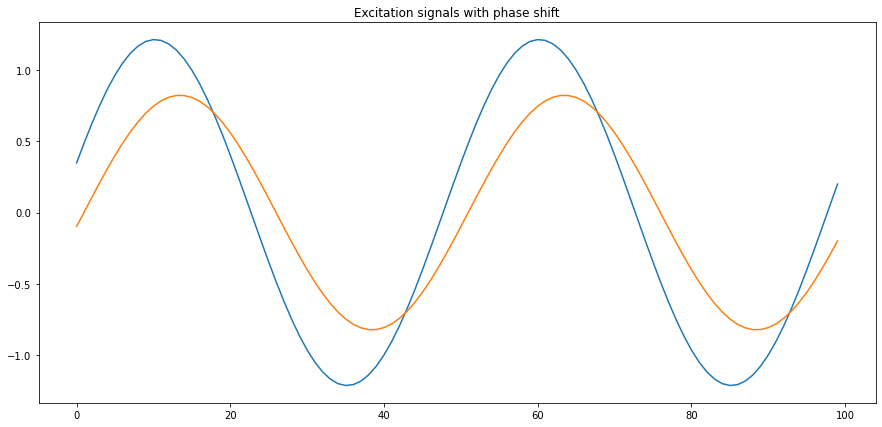

In [3]:
with nullcontext():
    lvdt = Lvdt(2*np.pi*2/100)
    plt.plot([lvdt(.2, 1) for _ in range(100)])
    plt.title('Excitation signals with phase shift')

In [4]:
class EKF:
    def __init__(self, P0):
        self.__P = np.asarray(P0)
        
    def __call__(self, A, C, Q, R):
        P = A@self.__P@A.T + Q # State covariance prediction
        S = C@P@C.T + R
        K = P@C.T@np.linalg.inv(S)
        self.__P = P - K@C@P
        return K
    
    def matrix(self):
        return self.__P
        

In [5]:
class System1:
    def __init__(self, x0, variances, ekf):
        for k,v in variances.items():
            setattr(self, k, v)
            
        self.__x = np.asarray(x0)
        self.__EKF = ekf
        
    @staticmethod
    def predict(x):
        """Predict the next state value"""
        c,s,sw = x[0:3]

        # 2nd order Taylor expansion of cw = np.sqrt(1. - sw^2)
        cw = 1 - sw*sw/2.
        
        x[0] = c*cw - s*sw
        x[1] = s*cw + c*sw

        return x
    
    @staticmethod
    def output(x):
        """Returns the measurement output given the state"""
        c,s,_,a,b = x
        return 2.*np.array((s, a*s + b*c))
    
    @staticmethod
    def Ak(x):
        """State transition matrix"""
        c,s,sw = x[0:3]
        return np.array([
            [1., -sw, -s, 0., 0.],
            [sw,  1.,  c, 0., 0.],
            [0.,  0., 1., 0., 0.],
            [0.,  0., 0., 1., 0.],
            [0.,  0., 0., 0., 1.],
        ])
        
    @staticmethod
    def Ck(x):
        """Output matrix"""
        c,s,sw,a,b = x
        return 2.*np.array([
            [0., 1., 0., 0., 0.],
            [ b,  a, 0.,  s,  c],
        ])
        
    def Qk(self, x):
        """State disturbance cross correlation matrix"""
        c,s = x[0:2]
        Vc = self.v_amplitude*c
        Vs = self.v_amplitude*s
        return np.array([
            [Vc*c, Vs*c,           0.,                  0.,           0.],
            [Vc*s, Vs*s,           0.,                  0.,           0.],
            [  0.,   0., self.v_omega,                  0.,           0.],
            [  0.,   0.,           0., self.v_displacement,           0.],
            [  0.,   0.,           0.,                  0., self.v_displacement],
        ])
    
    def Rk(self, x):
        """Measurement noise cross correlation matrix"""
        return 2.*self.v_measurement*np.eye(2)
    
    def update(self, z):
        x = self.predict(self.__x)
        
        Kf = self.__EKF(self.Ak(x), self.Ck(x), self.Qk(x), self.Rk(x))
        self.__x = x + Kf@(z - self.output(x))
        return self.__x


In [6]:
with nullcontext():
    s = System1((1.,1.,0.1,0.0, 0.),
                {'v_amplitude': 0.00001**2,
                 'v_omega': 0.000001**2,
                 'v_displacement': 0.00005**2,
                 'v_measurement': 0.001**2},
                EKF(np.zeros((5,5))))
    
    lvdt = Lvdt(2*np.pi*2/100)
    
    plt.plot([s.update(np.array(((1,1),(1,-1)))@lvdt(0.0 + 0.1*(i>400), 0.8)).take((2,3,4)) for i in range(1000)])
    plt.legend(('Frequency $s_\Omega$', 'LVDT position', 'LVDT phase'))
    plt.title('Frequency and position step response')
    plt.xlabel('Sample')
